In [1]:
# %%capture
# !pip install vit-pytorch
# !pip install datasets
# !pip install transformers

In [1]:
# import tensorflow as tf
import numpy as np 
import math
import random
import matplotlib.pyplot as plt
import os 
import sys
import librosa
import librosa.display
from warnings import warn
from IPython.display import Audio, display
from scipy import signal 
from scipy.io import wavfile
from collections import Counter
import time
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
print(torch.cuda.is_available())
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torchaudio
from torchaudio import transforms
from vit_pytorch import ViT
import torchvision

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

COLAB = False

True


In [2]:
if COLAB:
    from google.colab import drive
    drive_root = '/content/drive'
    drive.mount(drive_root)
    VIVAE_PATH = os.path.join(drive_root, "My Drive", "VIVAE", "full_set")
else:
    VIVAE_PATH = os.path.join("../VIVAE", "full_set")
    
audio_paths = [os.path.join(VIVAE_PATH, i) for i in os.listdir(VIVAE_PATH)]
audio_paths.sort()

In [3]:
def save_model(model, save_dir, epoch, test_loss, test_acc):
    model_folder_name = f'epoch_{epoch:05d}_test_loss_{test_loss:.5f}_test_acc_{test_acc:.3f}'
    if not os.path.exists(os.path.join(save_dir, model_folder_name)):
        os.makedirs(os.path.join(save_dir, model_folder_name))
    torch.save(model.state_dict(), os.path.join(save_dir, model_folder_name, 'model.pth'))
    
def save_torch_logs(EPOCHS, train_losses, train_accs, test_losses, test_accs, output_dir):
    logs_dict = {"epoch": [i for i in range(1,EPOCHS+1)],	
                 "train_loss": 	train_losses,
                 "train_accuracy": train_accs,
                 "eval_loss": test_losses,
                 "eval_accuracy": test_accs}
    df = pd.DataFrame(logs_dict)
    df.to_pickle(os.path.join(output_dir, "logs.pkl"))
    return df

def count_parameters(model):
    # https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_loss(df, title=None):
    plt.figure(figsize=(8,6))
    plt.plot(df["epoch"], df["train_loss"], label="Training Loss")
    plt.plot(df["epoch"], df["eval_loss"], label="Testing Loss")
    plt.legend()
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    if title:
        plt.title(title, fontsize=12)
    plt.show()

def plot_accuracy(df, title=None):
    plt.figure(figsize=(8,6))
    plt.plot(df["epoch"], df["train_accuracy"], label="Training Acc")
    plt.plot(df["epoch"], df["eval_accuracy"], label="Testing Acc")
    plt.legend()
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    if title:
        plt.title(title, fontsize=12)
    plt.show()

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

# Creation and Distribution of Labels

In [4]:
def all_labels(inp):
    emotion_type = []
    emotion_intensities = []
    emotion_labels = []

    for file_name in audio_paths:
        metadata = file_name.split("/")[-1].split("_")
        emotion_type.append(metadata[1]) 
        emotion_intensities.append(metadata[2])
        emotion_labels.append(metadata[1] + "_" + metadata[2])

    res = dict()

    if inp == "emotion_type":
        for i in emotion_type:
            if i not in res:
                res[i] = 1
            else:
                res[i] += 1
    elif inp == "emotion_intensity":
        for i in emotion_intensities:
            if i not in res:
                res[i] = 1
            else:
                res[i] += 1
    elif inp == "emotion_full_label":
        for i in emotion_labels:
            if i not in res:
                res[i] = 1
            else:
                res[i] += 1

    res = dict(sorted(res.items()))

    label_encoding = {}
    for count, val in enumerate(res):
        label_encoding[val] = count

    return label_encoding, res

LABEL_TYPE = "emotion_type"
LABEL_ENCODING, LABEL_COUNT = all_labels(LABEL_TYPE) 

LABEL_ENCODING

{'achievement': 0,
 'anger': 1,
 'fear': 2,
 'pain': 3,
 'pleasure': 4,
 'surprise': 5}

In [269]:
LABEL_COUNT

{'achievement': 161,
 'anger': 174,
 'fear': 176,
 'pain': 185,
 'pleasure': 202,
 'surprise': 187}

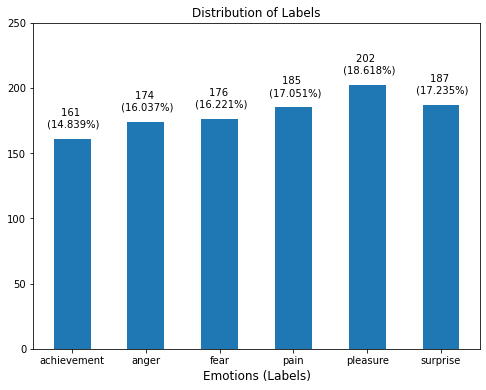

In [271]:
val = list(LABEL_COUNT.values())
fig, ax = plt.subplots(figsize=(8,6))
p1 = ax.bar(LABEL_COUNT.keys(), val, 0.5)
ax.set_xlabel("Emotions (Labels)", fontsize=12)
ax.bar_label(p1, labels=[f"{i} \n ({100*i/sum(val):.03f}%)" for i in val],
             padding=10)
ax.set_ylim(0,250)
ax.set_title("Distribution of Labels", fontsize=12)
plt.savefig("figs/distribution_of_labels.png")
plt.show()

# Creating Audio Class Using torchaudio 

In [5]:
class Audio():
    def __init__(self, audio_file, label_type, label_mapping):
        self.audio_file = audio_file
        self.open()
        self.set_labels(label_type, label_mapping)

    def open(self):
        self.audio, self.sr = torchaudio.load(self.audio_file)

    def set_labels(self, label_type, label_mapping):
        metadata = self.audio_file.split("/")[-1].split("_")
        self.subject = metadata[0]
        if label_type == "emotion_type":
            self.label = metadata[1]
        elif label_type == "emotion_intensity":
            self.label = metadata[2]
        elif label_type == "emotion_full_label":
            self.label = metadata[1] + "_" + metadata[2]
        self.label_encoding = label_mapping[self.label]

    def get_audio(self):
        return self.audio

    def plot_time_series(self, audio):
        t = np.arange(audio.size()[1])/self.sr
        plt.figure(figsize=(8,6))
        plt.plot(t, audio.squeeze().detach().numpy())
        plt.xlabel("Time (s)", fontsize=12)
        plt.title("Time Series", fontsize=12)
        plt.show()

    def mel_spectrogram(self, audio, hop_length=64, n_fft=1024, n_mels=64, top_db=80):
        spec = transforms.MelSpectrogram(self.sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)(audio)
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return spec

    def plot_mel_spectrogram(self, audio, hop_length=64, n_fft=1024, n_mels=64, top_db=80):
        spec = self.mel_spectrogram(audio, hop_length=hop_length, n_fft=n_fft, n_mels=n_mels, top_db=top_db).detach().squeeze().numpy()
        plt.figure(figsize=(8,6))
        librosa.display.specshow(spec, sr=self.sr, hop_length=hop_length, x_axis='time', y_axis='mel');
        plt.colorbar(format='%+2.0f dB');
        plt.title('Mel Spectrogram', fontsize=12);

    def get_mel_spectrogram_and_label(self, audio, n_mels):
        return self.mel_spectrogram(audio, n_mels=n_mels), self.label_encoding

    def get_time_series_and_label(self, audio):
        return audio.squeeze(), self.label_encoding

    def pad_time_series(self, audio, max_length):
        assert audio.dim() == 2, "Audio should be of dim 2"
        curr_len = audio.size()[1]

        # get beginning part of time series
        if curr_len > max_length:
            audio = audio[:,:max_length]
    
        # two sided padding
        elif curr_len < max_length:
            left = math.floor((max_length-curr_len)/2)
            right = (max_length-curr_len)-left
            audio = F.pad(audio, (left,right), "constant", 0)

        return audio  
  
    def resample(self, audio, sr, resample_sr):
        resampler = transforms.Resample(sr, resample_sr)
        resampled_audio = resampler(audio)
        return resampled_audio

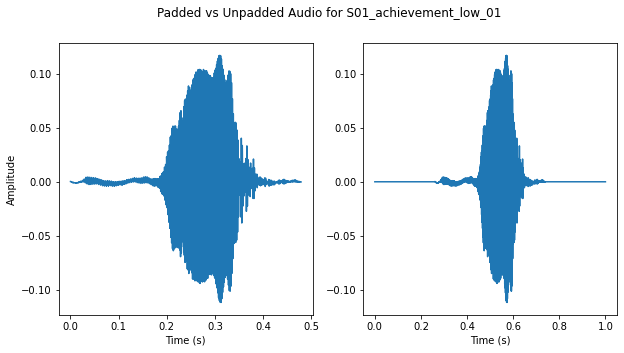

In [72]:
test = Audio(audio_paths[0], LABEL_TYPE, LABEL_ENCODING)
aud = test.get_audio()
padded_aud = test.pad_time_series(aud, 44100)

aud_np = aud.detach().squeeze().numpy()
padded_aud_np = padded_aud.detach().squeeze().numpy()

x1 = np.arange(len(aud_np))/44100
x2 = np.arange(len(padded_aud_np))/44100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Padded vs Unpadded Audio for S01_achievement_low_01')
ax1.plot(x1, aud_np)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
ax2.plot(x2, padded_aud_np)
ax2.set_xlabel('Time (s)')
plt.savefig("figs/padded_vs_unpadded_time_series.png")
plt.show()

# test.plot_mel_spectrogram(aud)
# test.plot_mel_spectrogram(padded_aud)


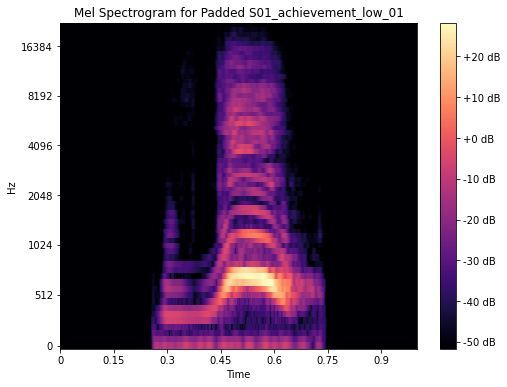

In [58]:
mel_spec = test.mel_spectrogram(padded_aud).detach().squeeze().numpy()

plt.figure(figsize=(8,6))
librosa.display.specshow(mel_spec, hop_length=64, sr=44100, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');
plt.title('Mel Spectrogram for Padded S01_achievement_low_01', fontsize=12);
plt.savefig("figs/mel_spec_padded.png")
plt.show()

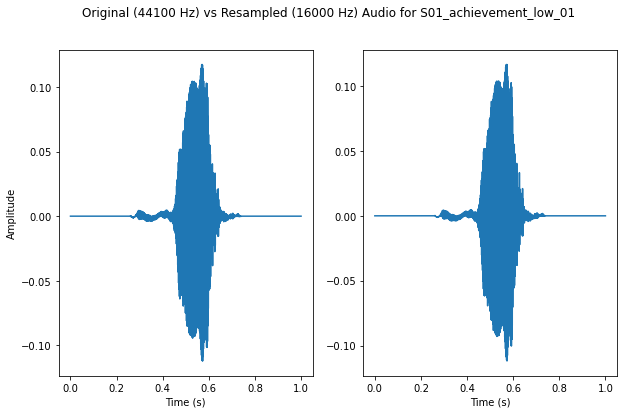

In [73]:
test = Audio(audio_paths[0], LABEL_TYPE, LABEL_ENCODING)
aud = test.get_audio()
padded_aud = test.pad_time_series(aud, 44100)
resample_aud = test.resample(padded_aud, 44100, 16000)

padded_aud_np = padded_aud.detach().squeeze().numpy()
resample_aud_np = resample_aud.detach().squeeze().numpy()
x2 = np.arange(len(padded_aud_np))/44100
x3 = np.arange(len(resample_aud_np))/16000

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
fig.suptitle('Original (44100 Hz) vs Resampled (16000 Hz) Audio for S01_achievement_low_01')

ax1.plot(x2, padded_aud_np)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

ax2.plot(x3, resample_aud_np)
ax2.set_xlabel('Time (s)')
plt.savefig("figs/resampled_time_series.png")
plt.show()

# Creating Dataset for PyTorch

In [247]:
audio_lengths = []
for count, i in enumerate(audio_paths):
    if count % 200 == 0:
        print(count)
    aud, sr = torchaudio.load(i)
    audio_lengths.append(aud.size()[1])

0
200
400
600
800
1000


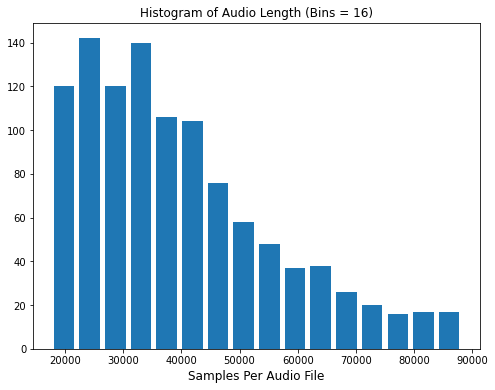

In [264]:
num_bins = 16
plt.figure(figsize=(8,6))
plt.title(f"Histogram of Audio Length (Bins = {num_bins})", fontsize = 12)
n, bins, patches = plt.hist(audio_lengths, num_bins, rwidth=0.8)
plt.xlabel("Samples Per Audio File", fontsize = 12)
plt.savefig("figs/distribution_of_audio_lengths.png")
plt.show()

In [261]:
print(np.floor(np.mean(audio_lengths)))
print(np.min(audio_lengths))
print(np.max(audio_lengths))
print(np.median(audio_lengths))

39819.0
17619
88200
35732.0


In [16]:
# Longest Audio Clip is 88200 samples
# max_length = 0

# for count, i in enumerate(audio_paths):
#   if count % 100 == 0:
#     print(count)

#   aud, sr = torchaudio.load(i)
#   if aud.size()[1] > max_length:
#     max_length = aud.size()[1]
#     j = i
# print(max_length)
# print(j)

# aud, _ = torchaudio.load("/content/drive/My Drive/VIVAE/full_set/S03_anger_moderate_01.wav")
aud, _ = torchaudio.load("../VIVAE/full_set/S03_anger_moderate_01.wav")
print(aud.size())

0
100
200
300
400
500
600
700
800
900
1000
88200
../VIVAE/full_set/S03_anger_moderate_01.wav
torch.Size([1, 88200])


In [45]:
class AudioDatasetViT(Dataset):
    def __init__(self, audio_paths, label_type, label_mapping, padding, transform=None):
        super(AudioDatasetViT, self).__init__()
        self.audio_paths = audio_paths
        self.label_type = label_type 
        self.label_mapping = label_mapping
        self.padding = padding
        self.transform = transform

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio = Audio(self.audio_paths[idx], self.label_type, self.label_mapping)
        audio_padded = audio.pad_time_series(audio.get_audio(), self.padding)
        if self.transform:
            im, label = audio.get_mel_spectrogram_and_label(audio_padded, n_mels=64)
            im = im.repeat(3, 1, 1)
            # print(im.shape)
            return self.transform(im), label
        return audio.get_mel_spectrogram_and_label(audio_padded, n_mels=64)
    
class AudioDatasetMLP(Dataset):
    def __init__(self, audio_paths, label_type, label_mapping, padding):
        super(AudioDatasetMLP, self).__init__()
        self.audio_paths = audio_paths
        self.label_type = label_type 
        self.label_mapping = label_mapping
        self.padding = padding

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio = Audio(self.audio_paths[idx], self.label_type, self.label_mapping)
        audio_padded = audio.pad_time_series(audio.get_audio(), self.padding)
        return audio.get_time_series_and_label(audio_padded)

In [21]:
# dataset = AudioDataset(audio_paths, LABEL_TYPE, LABEL_ENCODING)
# loader = DataLoader(dataset, shuffle=1, batch_size=10)

# dataset[1084][0].shape

torch.Size([1, 64, 690])

In [64]:
audio_arrays = np.load(os.path.join("./saved_arrays/", 'audio_arrays.npy'))
labels_arrays = np.load(os.path.join("./saved_arrays/", 'labels_arrays.npy'))
X_train, X_test, y_train, y_test = train_test_split(audio_arrays, labels_arrays, test_size=0.2, random_state=42)

# Logistic Regression

In [36]:
# audio_classes = []

# for count, i in enumerate(audio_paths):
#   if count % 100 == 0:
#     print(count)
#   audio_classes.append(Audio(i, LABEL_TYPE, LABEL_ENCODING))

# audio_arrays = []
# labels_arrays = []
# for i in audio_classes:
#   audio_padded = i.pad_time_series(i.get_audio(), 44100)
#   a,b = i.get_time_series_and_label(audio_padded)
#   audio_arrays.append(a.numpy())
#   labels_arrays.append(b)

# np.save(os.path.join("./saved_arrays/", 'audio_arrays.npy'), audio_arrays)
# np.save(os.path.join("./saved_arrays/", 'labels_arrays.npy'), labels_arrays)

In [38]:
audio_arrays = np.load(os.path.join("./saved_arrays/", 'audio_arrays.npy'))
labels_arrays = np.load(os.path.join("./saved_arrays/", 'labels_arrays.npy'))
X_train_logreg, X_test_logreg, y_train_logreg, y_test_logreg = train_test_split(audio_arrays, labels_arrays, test_size=0.2, random_state=42)

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model_logreg = LogisticRegression(penalty = "l2", 
                                   max_iter = 100)
model_logreg.fit(X_train_logreg, 
                 y_train_logreg) # 
y_predict = model_logreg.predict(X_test_logreg) 
accuracy = model_logreg.score(X_test_logreg,
                              y_test_logreg)
print(accuracy) # 1-sum(abs(y_test.to_numpy().flatten() - y_predict))/len(y_predict)

0.2073732718894009


In [40]:
model_logreg.score(X_train_logreg, 
                   y_train_logreg)

0.9550691244239631

# MLP

In [42]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 100)
        self.fc2 = nn.Linear(100, 200)
        self.fc3 = nn.Linear(200, 60)
        self.fc4 = nn.Linear(60, output_dim)
        self.dropout = nn.Dropout(0.25)
        # self.bn = nn.BatchNorm1d(44100)
    def forward(self, x):
        # x = self.bn(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [14]:
count_parameters(MLP(44100,6))

4442726

In [46]:
padding = 44100

dataset = AudioDatasetMLP(audio_paths, LABEL_TYPE, LABEL_ENCODING, padding)
dataset_size = len(dataset)

split = 0.2 # Train-Test split is 80% 20%
test_size = int(np.floor(split * dataset_size))
train_size = dataset_size - test_size
train_set_MLP, test_set_MLP = random_split(dataset, [train_size, test_size])

batch_size = 30
train_loader_MLP = DataLoader(train_set_MLP, 
                          shuffle = True, 
                          batch_size = batch_size)
test_loader_MLP = DataLoader(test_set_MLP, 
                        shuffle = True, 
                        batch_size = batch_size)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(padding, 6).to(device)

learning_rate = 0.00002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-6) # 1e-6
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=10,  
                                            gamma=1)

In [18]:
%%time
output_dir = f"./MLP/"
output_dir = os.path.join(output_dir, time.strftime("%Y-%m-%d_%H-%M-%S"))

EPOCHS = 100

train_losses = []
train_accs = []

test_losses = []
test_accs = []

print("MLP")
start = time.time()
for epoch in range(1, EPOCHS+1):
    train_loss = 0.0
    train_acc = 0.0
    for i, data in enumerate(train_loader_MLP):
        features, labels = data
        features = features.to(device)
        labels = labels.type(torch.LongTensor).to(device)
        predictions = model(features)

        loss = criterion(predictions,labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        scheduler.step()
        train_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    with torch.no_grad():
        test_loss = 0.0 
        test_acc = 0.0
        for i, data in enumerate(test_loader_MLP):
            features, labels = data
            features = features.to(device)
            labels = labels.to(device)
            predictions = model(features)

            loss = criterion(predictions, labels)
            test_loss += loss.item()

            test_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acc = 100*train_acc.item()/len(train_set_MLP)
    test_acc = 100*test_acc.item()/len(test_set_MLP)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if epoch % 1 == 0: # takes 100 seconds to run 100 epochs
        save_model(model, output_dir, epoch, test_loss, test_acc)

    print(f"Epoch: {epoch} Train Loss: {round(train_loss,4)} Test Loss: {round(test_loss,4)} Train Acc: {round(train_acc,4)}% Test Acc: {round(test_acc,4)}%")
    
print(f"Done training after {time.time()-start} seconds")

df_MLP = save_torch_logs(EPOCHS, train_losses, train_accs, test_losses, test_accs, output_dir)

MLP
Epoch: 1 Train Loss: 52.0968 Test Loss: 14.3219 Train Acc: 17.9724% Test Acc: 21.1982%
Epoch: 2 Train Loss: 52.0139 Test Loss: 14.296 Train Acc: 18.4332% Test Acc: 21.1982%
Epoch: 3 Train Loss: 51.9632 Test Loss: 14.2979 Train Acc: 18.5484% Test Acc: 21.1982%
Epoch: 4 Train Loss: 51.9029 Test Loss: 14.2799 Train Acc: 19.1244% Test Acc: 21.1982%
Epoch: 5 Train Loss: 51.8308 Test Loss: 14.2936 Train Acc: 20.0461% Test Acc: 21.1982%
Epoch: 6 Train Loss: 51.7742 Test Loss: 14.2897 Train Acc: 20.5069% Test Acc: 21.1982%
Epoch: 7 Train Loss: 51.6995 Test Loss: 14.3294 Train Acc: 22.235% Test Acc: 21.1982%
Epoch: 8 Train Loss: 51.6158 Test Loss: 14.2855 Train Acc: 21.659% Test Acc: 21.659%
Epoch: 9 Train Loss: 51.5361 Test Loss: 14.347 Train Acc: 23.0415% Test Acc: 21.659%
Epoch: 10 Train Loss: 51.4254 Test Loss: 14.2795 Train Acc: 24.5392% Test Acc: 21.659%
Epoch: 11 Train Loss: 51.2792 Test Loss: 14.3293 Train Acc: 25.576% Test Acc: 22.5806%
Epoch: 12 Train Loss: 51.1759 Test Loss: 14.3

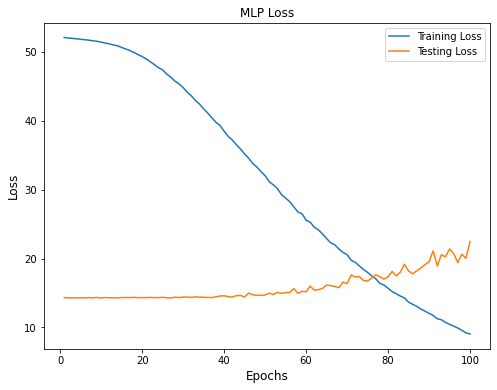

In [19]:
plot_loss(df_MLP, title="MLP Loss")

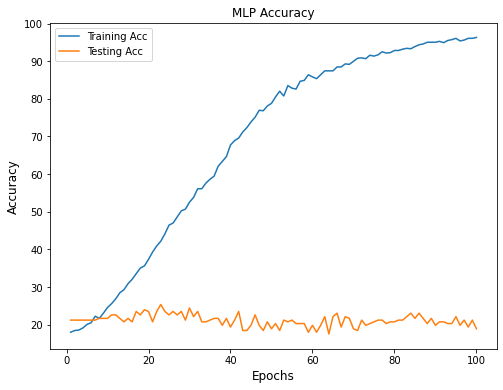

In [20]:
plot_accuracy(df_MLP, title="MLP Accuracy")

In [21]:
df_MLP

,epoch,train_loss,train_accuracy,eval_loss,eval_accuracy
0,1,52.096760,17.972350,14.321895,21.198157
1,2,52.013947,18.433180,14.295991,21.198157
2,3,51.963153,18.548387,14.297880,21.198157
3,4,51.902900,19.124424,14.279945,21.198157
4,5,51.830778,20.046083,14.293565,21.198157
...,...,...,...,...,...
95,96,10.186578,95.391705,20.713733,19.815668
96,97,9.904763,95.622120,19.409014,21.198157
97,98,9.572058,96.082949,20.611058,19.354839
98,99,9.207569,96.082949,20.033133,21.198157


# ViT

In [49]:
padding = 44100

dataset = AudioDatasetViT(audio_paths, LABEL_TYPE, LABEL_ENCODING, padding)
dataset_size = len(dataset)

split = 0.2 # Train-Test split is 80% 20%
test_size = int(np.floor(split * dataset_size))
train_size = dataset_size - test_size
train_set_ViT, test_set_ViT = random_split(dataset, [train_size, test_size])

batch_size = 30
# Shape should be BATCH, 1 (Mono Channel), N_MELS, TIME_BINS -> torch.Size([8, 1, 64, 1379])
train_loader_ViT = DataLoader(train_set_ViT, 
                              shuffle = True, 
                              batch_size = batch_size)
test_loader_ViT = DataLoader(test_set_ViT, 
                            shuffle = True, 
                            batch_size = batch_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## ViT (32, 30)


In [17]:
#44100
patch_size = (32, 30)
model = ViT(
    image_size = (64, 690),
    patch_size = patch_size,
    num_classes = 6,
    dim = 200,
    depth = 5,
    heads = 16,
    mlp_dim = 300,
    dropout = 0.05,
    emb_dropout = 0.05,
    channels = 1
).to(device)

learning_rate = 0.000005 # 0.00002
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay = 1e-6)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=50,  
                                            gamma=0.98)

In [11]:
%%time
output_dir = f"./ViT_models_{patch_size[0]}_{patch_size[1]}/"
output_dir = os.path.join(output_dir, time.strftime("%Y-%m-%d_%H-%M-%S"))

EPOCHS = 400

train_losses = []
train_accs = []

test_losses = []
test_accs = []

print("ViT")
start = time.time()

for epoch in range(1, EPOCHS+1):
    train_loss = 0.0
    train_acc = 0.0
    for i, data in enumerate(train_loader_ViT):
        features, labels = data
        features = features.to(device)
        labels = labels.to(device)
        predictions = model(features)

        loss = criterion(predictions,labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        scheduler.step()
        train_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    with torch.no_grad():
        test_loss = 0.0 
        test_acc = 0.0
        for i, data in enumerate(test_loader_ViT):
            features, labels = data
            features = features.to(device)
            labels = labels.to(device)
            predictions = model(features)

            loss = criterion(predictions, labels)
            test_loss += loss.item()

            test_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acc = 100*train_acc.item()/len(train_set_ViT)
    test_acc = 100*test_acc.item()/len(test_set_ViT)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    if epoch % 5 == 0:
        save_model(model, output_dir, epoch, test_loss, test_acc)

    print(f"Epoch: {epoch} Train Loss: {round(train_loss,4)} Test Loss: {round(test_loss,4)} Train Acc: {round(train_acc,4)}% Test Acc: {round(test_acc,4)}%")
    
print(f"Done training after {time.time()-start} seconds")

df_ViT1 = save_torch_logs(EPOCHS, train_losses, train_accs, test_losses, test_accs, output_dir)

ViT
Epoch: 1 Train Loss: 53.8201 Test Loss: 14.2807 Train Acc: 18.0876% Test Acc: 21.1982%
Epoch: 2 Train Loss: 51.7992 Test Loss: 14.0325 Train Acc: 18.5484% Test Acc: 25.8065%
Epoch: 3 Train Loss: 51.3827 Test Loss: 14.1401 Train Acc: 23.2719% Test Acc: 25.3456%
Epoch: 4 Train Loss: 51.0606 Test Loss: 13.9932 Train Acc: 24.3088% Test Acc: 21.659%
Epoch: 5 Train Loss: 50.828 Test Loss: 13.7486 Train Acc: 25.1152% Test Acc: 28.5714%
Epoch: 6 Train Loss: 50.3734 Test Loss: 13.7718 Train Acc: 25.9217% Test Acc: 34.5622%
Epoch: 7 Train Loss: 49.9409 Test Loss: 13.8664 Train Acc: 29.3779% Test Acc: 31.7972%
Epoch: 8 Train Loss: 49.9577 Test Loss: 13.7446 Train Acc: 28.1106% Test Acc: 30.8756%
Epoch: 9 Train Loss: 49.546 Test Loss: 13.5273 Train Acc: 30.1843% Test Acc: 31.3364%
Epoch: 10 Train Loss: 49.2659 Test Loss: 13.452 Train Acc: 30.9908% Test Acc: 33.1797%
Epoch: 11 Train Loss: 49.3388 Test Loss: 13.5587 Train Acc: 28.9171% Test Acc: 35.4839%
Epoch: 12 Train Loss: 49.0103 Test Loss: 

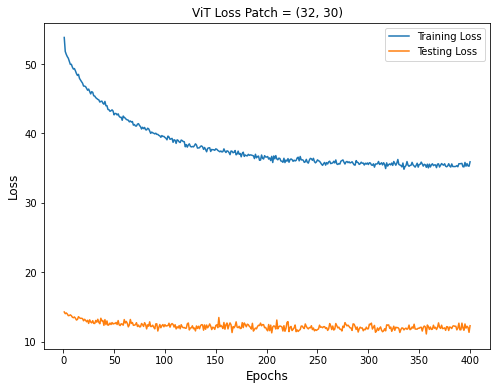

In [12]:
plot_loss(df_ViT1, title=f"ViT Loss Patch = {patch_size}")

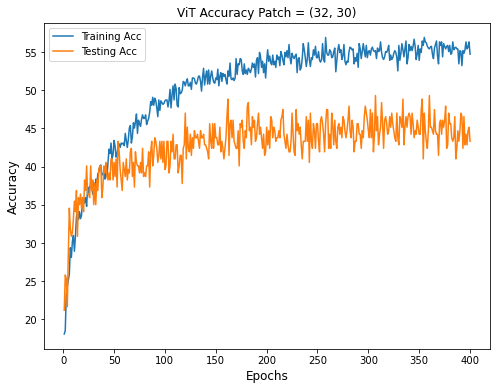

In [13]:
plot_accuracy(df_ViT1, title=f"ViT Accuracy Patch = {patch_size}")

In [34]:
# x, y = next(iter(train_loader))
# x = x.to(device)
# y = y.to(device)

# model.eval()
# (torch.argmax(model(x), dim=1) == y).float().mean()

## ViT (16, 69)

In [21]:
# 88200
# model = ViT(
#     image_size = (64, 1379),
#     patch_size = (32, 197),
#     num_classes = 6,
#     dim = 1024,
#     depth = 6,
#     heads = 16,
#     mlp_dim = 2048,
#     dropout = 0.1,
#     emb_dropout = 0.1,
#     channels = 1
# ).to(device)

#44100
patch_size = (16, 69)
model = ViT(
    image_size = (64, 690),
    patch_size = patch_size,
    num_classes = 6,
    dim = 200,
    depth = 5,
    heads = 16,
    mlp_dim = 300,
    dropout = 0.05,
    emb_dropout = 0.05,
    channels = 1
).to(device)

learning_rate = 0.000005 # 0.00002
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay = 1e-6)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=50,  
                                            gamma=0.98)

In [18]:
%%time
output_dir = f"./ViT_models_{patch_size[0]}_{patch_size[1]}/"
output_dir = os.path.join(output_dir, time.strftime("%Y-%m-%d_%H-%M-%S"))

EPOCHS = 400

train_losses = []
train_accs = []

test_losses = []
test_accs = []

print("ViT")
start = time.time()

for epoch in range(1, EPOCHS+1):
    train_loss = 0.0
    train_acc = 0.0
    for i, data in enumerate(train_loader_ViT):
        features, labels = data
        features = features.to(device)
        labels = labels.to(device)
        predictions = model(features)

        loss = criterion(predictions,labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        scheduler.step()
        train_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    with torch.no_grad():
        test_loss = 0.0 
        test_acc = 0.0
        for i, data in enumerate(test_loader_ViT):
            features, labels = data
            features = features.to(device)
            labels = labels.to(device)
            predictions = model(features)

            loss = criterion(predictions, labels)
            test_loss += loss.item()

            test_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acc = 100*train_acc.item()/len(train_set_ViT)
    test_acc = 100*test_acc.item()/len(test_set_ViT)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    if epoch % 5 == 0:
        save_model(model, output_dir, epoch, test_loss, test_acc)

    print(f"Epoch: {epoch} Train Loss: {round(train_loss,4)} Test Loss: {round(test_loss,4)} Train Acc: {round(train_acc,4)}% Test Acc: {round(test_acc,4)}%")
    
print(f"Done training after {time.time()-start} seconds")

df_ViT2 = save_torch_logs(EPOCHS, train_losses, train_accs, test_losses, test_accs, output_dir)

ViT
Epoch: 1 Train Loss: 52.5392 Test Loss: 14.5265 Train Acc: 17.5115% Test Acc: 13.8249%
Epoch: 2 Train Loss: 52.2113 Test Loss: 14.4014 Train Acc: 17.5115% Test Acc: 17.9724%
Epoch: 3 Train Loss: 51.7905 Test Loss: 14.3775 Train Acc: 19.1244% Test Acc: 17.9724%
Epoch: 4 Train Loss: 52.2518 Test Loss: 14.1765 Train Acc: 18.0876% Test Acc: 24.8848%
Epoch: 5 Train Loss: 51.4961 Test Loss: 14.3016 Train Acc: 24.8848% Test Acc: 22.5806%
Epoch: 6 Train Loss: 51.3271 Test Loss: 14.1453 Train Acc: 25.1152% Test Acc: 23.0415%
Epoch: 7 Train Loss: 51.1807 Test Loss: 14.1395 Train Acc: 24.1935% Test Acc: 23.9631%
Epoch: 8 Train Loss: 51.0414 Test Loss: 14.1714 Train Acc: 25.6912% Test Acc: 24.424%
Epoch: 9 Train Loss: 50.7798 Test Loss: 14.0838 Train Acc: 25.9217% Test Acc: 22.1198%
Epoch: 10 Train Loss: 50.6316 Test Loss: 14.062 Train Acc: 28.6866% Test Acc: 24.424%
Epoch: 11 Train Loss: 50.3742 Test Loss: 13.9662 Train Acc: 27.765% Test Acc: 28.1106%
Epoch: 12 Train Loss: 50.1663 Test Loss: 

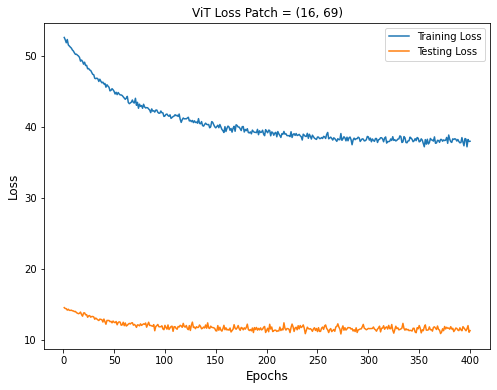

In [19]:
plot_loss(df_ViT2, title=f"ViT Loss Patch = {patch_size}")

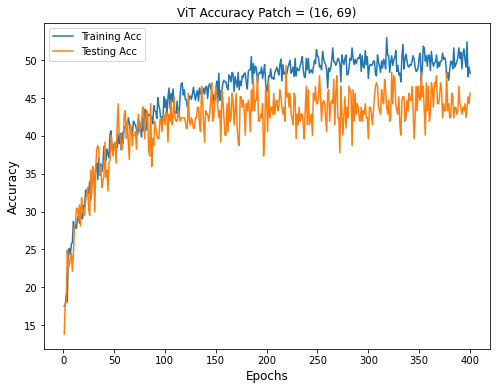

In [20]:
plot_accuracy(df_ViT2, title=f"ViT Accuracy Patch = {patch_size}")

## ViT (8, 23)

In [23]:
# 88200
# model = ViT(
#     image_size = (64, 1379),
#     patch_size = (32, 197),
#     num_classes = 6,
#     dim = 1024,
#     depth = 6,
#     heads = 16,
#     mlp_dim = 2048,
#     dropout = 0.1,
#     emb_dropout = 0.1,
#     channels = 1
# ).to(device)

#44100
patch_size = (8, 23)
model = ViT(
    image_size = (64, 690),
    patch_size = patch_size,
    num_classes = 6,
    dim = 200,
    depth = 5,
    heads = 16,
    mlp_dim = 300,
    dropout = 0.05,
    emb_dropout = 0.05,
    channels = 1
).to(device)

learning_rate = 0.000005 # 0.00002
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay = 1e-6)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=50,  
                                            gamma=0.98)

In [26]:
%%time
output_dir = f"./ViT_models_{patch_size[0]}_{patch_size[1]}/"
output_dir = os.path.join(output_dir, time.strftime("%Y-%m-%d_%H-%M-%S"))

EPOCHS = 400

train_losses = []
train_accs = []

test_losses = []
test_accs = []

print("ViT")
start = time.time()

for epoch in range(1, EPOCHS+1):
    train_loss = 0.0
    train_acc = 0.0
    for i, data in enumerate(train_loader_ViT):
        features, labels = data
        features = features.to(device)
        labels = labels.to(device)
        predictions = model(features)

        loss = criterion(predictions,labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        scheduler.step()
        train_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    with torch.no_grad():
        test_loss = 0.0 
        test_acc = 0.0
        for i, data in enumerate(test_loader_ViT):
            features, labels = data
            features = features.to(device)
            labels = labels.to(device)
            predictions = model(features)

            loss = criterion(predictions, labels)
            test_loss += loss.item()

            test_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acc = 100*train_acc.item()/len(train_set_ViT)
    test_acc = 100*test_acc.item()/len(test_set_ViT)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    if epoch % 5 == 0:
        save_model(model, output_dir, epoch, test_loss, test_acc)

    print(f"Epoch: {epoch} Train Loss: {round(train_loss,4)} Test Loss: {round(test_loss,4)} Train Acc: {round(train_acc,4)}% Test Acc: {round(test_acc,4)}%")
    
print(f"Done training after {time.time()-start} seconds")

df_ViT3 = save_torch_logs(EPOCHS, train_losses, train_accs, test_losses, test_accs, output_dir)

ViT (8, 23)
Epoch: 1 Train Loss: 54.0973 Test Loss: 14.6526 Train Acc: 15.553% Test Acc: 15.2074%
Epoch: 2 Train Loss: 52.5591 Test Loss: 14.4526 Train Acc: 13.7097% Test Acc: 17.0507%
Epoch: 3 Train Loss: 52.5348 Test Loss: 14.461 Train Acc: 14.1705% Test Acc: 15.2074%
Epoch: 4 Train Loss: 52.3532 Test Loss: 14.4687 Train Acc: 16.5899% Test Acc: 17.5115%
Epoch: 5 Train Loss: 52.4208 Test Loss: 14.5407 Train Acc: 17.0507% Test Acc: 14.2857%
Epoch: 6 Train Loss: 52.0686 Test Loss: 14.3353 Train Acc: 18.5484% Test Acc: 23.0415%
Epoch: 7 Train Loss: 51.8769 Test Loss: 14.2256 Train Acc: 19.5853% Test Acc: 22.5806%
Epoch: 8 Train Loss: 51.7559 Test Loss: 14.3164 Train Acc: 20.2765% Test Acc: 22.5806%
Epoch: 9 Train Loss: 51.7676 Test Loss: 14.2367 Train Acc: 20.0461% Test Acc: 21.659%
Epoch: 10 Train Loss: 51.7741 Test Loss: 14.3181 Train Acc: 21.5438% Test Acc: 20.7373%
Epoch: 11 Train Loss: 51.7162 Test Loss: 14.405 Train Acc: 20.2765% Test Acc: 22.5806%
Epoch: 12 Train Loss: 51.5135 Tes

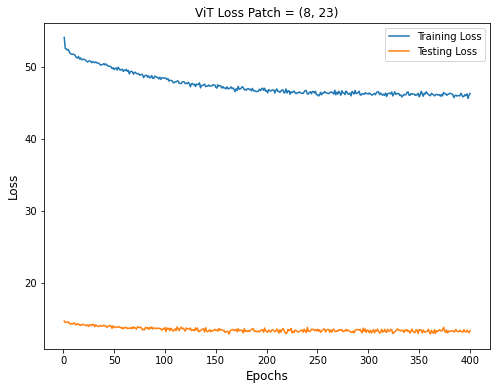

In [27]:
plot_loss(df_ViT3, title=f"ViT Loss Patch = {patch_size}")

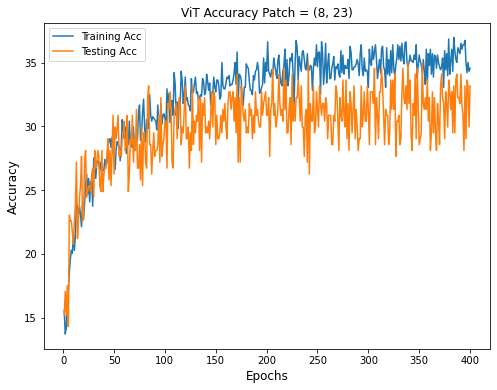

In [28]:
plot_accuracy(df_ViT3, title=f"ViT Accuracy Patch = {patch_size}")

## Pretrained ViT-Base

In [20]:
class AudioDatasetViTPretrain(Dataset):
    def __init__(self, audio_paths, label_type, label_mapping, transform=None):
        super(AudioDatasetViTPretrain, self).__init__()
        self.audio_paths = audio_paths
        self.label_type = label_type 
        self.label_mapping = label_mapping
        self.transform = transform

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio = Audio(self.audio_paths[idx], self.label_type, self.label_mapping)
        if self.transform:
            im, label = audio.get_mel_spectrogram_and_label(audio.get_audio(), n_mels=64)
            im = im.repeat(3, 1, 1)
            return self.transform(im), label
        return audio.get_mel_spectrogram_and_label(audio_padded, n_mels=64)

In [16]:
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=6, in_chans=3)
model = model.to(device)
config = resolve_data_config({}, model=model)
transform = create_transform(**config)
transform.transforms.insert(0,torchvision.transforms.ToPILImage()) # first converts tensor into Pil Image then uses same transforms in paper

In [21]:
padding = 44100
dataset = AudioDatasetViTPretrain(audio_paths, LABEL_TYPE, LABEL_ENCODING, transform=transform)
dataset_size = len(dataset)

split = 0.2 # Train-Test split is 80% 20%
test_size = int(np.floor(split * dataset_size))
train_size = dataset_size - test_size
train_set_ViT_transform, test_set_ViT_transform = random_split(dataset, [train_size, test_size])

batch_size = 30
# Shape should be BATCH, 1 (Mono Channel), N_MELS, TIME_BINS -> torch.Size([8, 1, 64, 1379])
train_loader_ViT_transform = DataLoader(train_set_ViT_transform, 
                              shuffle = True, 
                              batch_size = batch_size)
test_loader_ViT_transform = DataLoader(test_set_ViT_transform, 
                            shuffle = True, 
                            batch_size = batch_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [42]:
#44100
learning_rate = 0.000005 # 0.00002
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay = 1e-6)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=50,  
                                            gamma=0.98)

In [43]:
%%time
output_dir = f"./ViT_pretrain/"
output_dir = os.path.join(output_dir, time.strftime("%Y-%m-%d_%H-%M-%S"))

EPOCHS = 100

train_losses = []
train_accs = []

test_losses = []
test_accs = []

print("ViT")
start = time.time()

for epoch in range(1, EPOCHS+1):
    train_loss = 0.0
    train_acc = 0.0
    for i, data in enumerate(train_loader_ViT_transform):
        features, labels = data
        features = features.to(device)
        labels = labels.to(device)
        predictions = model(features)

        loss = criterion(predictions,labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        scheduler.step()
        train_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    with torch.no_grad():
        test_loss = 0.0 
        test_acc = 0.0
        for i, data in enumerate(test_loader_ViT_transform):
            features, labels = data
            features = features.to(device)
            labels = labels.to(device)
            predictions = model(features)

            loss = criterion(predictions, labels)
            test_loss += loss.item()

            test_acc += (torch.argmax(predictions, dim=1) == labels).float().sum()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acc = 100*train_acc.item()/len(train_set_ViT_transform)
    test_acc = 100*test_acc.item()/len(test_set_ViT_transform)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    if epoch % 1 == 0:
        save_model(model, output_dir, epoch, test_loss, test_acc)

    print(f"Epoch: {epoch} Train Loss: {round(train_loss,4)} Test Loss: {round(test_loss,4)} Train Acc: {round(train_acc,4)}% Test Acc: {round(test_acc,4)}%")
    
print(f"Done training after {time.time()-start} seconds")

df_ViT_pretrain = save_torch_logs(EPOCHS, train_losses, train_accs, test_losses, test_accs, output_dir)

ViT
Epoch: 1 Train Loss: 54.5212 Test Loss: 13.8429 Train Acc: 19.47% Test Acc: 25.8065%
Epoch: 2 Train Loss: 49.6144 Test Loss: 14.4125 Train Acc: 26.6129% Test Acc: 20.2765%
Epoch: 3 Train Loss: 47.7712 Test Loss: 13.9323 Train Acc: 31.7972% Test Acc: 26.7281%
Epoch: 4 Train Loss: 43.4939 Test Loss: 14.0905 Train Acc: 40.3226% Test Acc: 25.3456%
Epoch: 5 Train Loss: 38.2138 Test Loss: 15.7465 Train Acc: 49.6544% Test Acc: 19.8157%
Epoch: 6 Train Loss: 31.1942 Test Loss: 15.2216 Train Acc: 61.2903% Test Acc: 23.5023%
Epoch: 7 Train Loss: 22.7024 Test Loss: 16.7748 Train Acc: 73.2719% Test Acc: 23.5023%
Epoch: 8 Train Loss: 15.6714 Test Loss: 17.8689 Train Acc: 83.4101% Test Acc: 23.5023%
Epoch: 9 Train Loss: 8.3394 Test Loss: 20.4244 Train Acc: 93.6636% Test Acc: 21.1982%
Epoch: 10 Train Loss: 3.1436 Test Loss: 22.7584 Train Acc: 99.3088% Test Acc: 22.5806%
Epoch: 11 Train Loss: 1.2889 Test Loss: 23.9649 Train Acc: 99.8848% Test Acc: 22.1198%
Epoch: 12 Train Loss: 0.4144 Test Loss: 29

KeyboardInterrupt: 

In [47]:
df_ViT_pretrain = save_torch_logs(54, train_losses, train_accs, test_losses, test_accs, output_dir)

In [8]:
df_ViT_pretrain = pd.read_pickle("./ViT_pretrain/2022-05-04_22-36-03/logs.pkl")

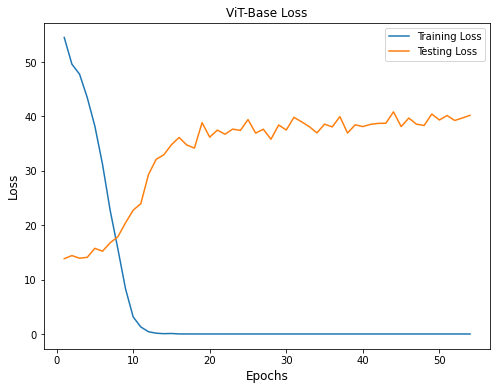

In [10]:
plot_loss(df_ViT_pretrain, title=f"ViT-Base Loss")

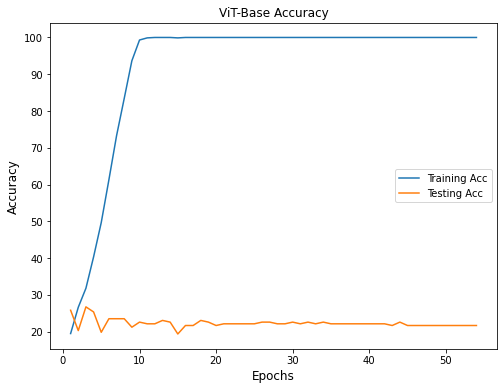

In [11]:
plot_accuracy(df_ViT_pretrain, title=f"ViT-Base Accuracy")

# Using wav2vec2 from HuggingFace

In [27]:
from datasets import Dataset as HFDataset, DatasetDict, load_metric, Audio as HFAudio, ClassLabel

dataset_dir = "/home/jupyter/VIVAE/full_set/"

abs_audio_paths = [os.path.join(dataset_dir, i) for i in os.listdir(dataset_dir)] # must be absolute path
abs_audio_paths_label = [LABEL_ENCODING[i.split("/")[-1].split("_")[1]] for i in abs_audio_paths] # gives number of class label

abs_audio_paths_dict = {"audio": abs_audio_paths, "label": abs_audio_paths_label}
dataset = HFDataset.from_dict(abs_audio_paths_dict)

# https://huggingface.co/docs/datasets/audio_process#resample
dataset = dataset.cast_column("audio", HFAudio(sampling_rate=44100, mono=True)) # turn audio path into actual audio with sampling rate
dataset = dataset.cast_column("label", ClassLabel(num_classes=6, names=list(LABEL_ENCODING.keys())))

dataset = dataset.train_test_split(test_size=0.2, shuffle=True, seed=SEED) # convert Dataset to DatasetDict with training and testing splits

dataset

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 868
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 217
    })
})

In [69]:
for i in range(len(dataset["train"])):
    if i < 3:
        print(f'sr: {dataset["train"][i]["audio"]["sampling_rate"]}')
        print(f'samples: {len(dataset["train"][i]["audio"]["array"])}')
    else: 
        break
        
assert dataset["train"].features == dataset["test"].features, "Should be same datatypes"
dataset["train"].features

sr: 44100
samples: 57160
sr: 44100
samples: 63439
sr: 44100
samples: 28444


{'audio': Audio(sampling_rate=44100, mono=True, decode=True, id=None),
 'label': ClassLabel(num_classes=6, names=['achievement', 'anger', 'fear', 'pain', 'pleasure', 'surprise'], id=None)}

In [28]:
from transformers import AutoFeatureExtractor

model_checkpoint = "facebook/wav2vec2-base-960h"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

In [29]:
max_duration = 1 # second
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(audio_arrays, 
                               sampling_rate=feature_extractor.sampling_rate, 
                               max_length=int(feature_extractor.sampling_rate*max_duration), 
                               truncation=True,)
    return inputs

In [30]:
encoded_dataset = dataset.map(preprocess_function, remove_columns=["audio"], batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# encoded_dataset["train"][0:2]["input_values"]

In [73]:
preprocess_function(dataset["train"][:2])["input_values"]

[array([1.6856360e-03, 2.5933052e-03, 2.8958614e-03, ..., 1.8109726e+00,
        1.9374411e+00, 1.9259440e+00], dtype=float32),
 array([-0.11270893, -0.12212291, -0.07505299, ..., -0.28216064,
        -0.2633327 , -0.28216064], dtype=float32)]

In [ ]:
# for i in range(len(encoded_dataset["train"])):
#     if i < 10:
#         # print(dataset["train"][i]["audio"]["sampling_rate"])
#         print(len(encoded_dataset["train"][i]["input_values"]))
#     else: 
#         break

In [31]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

label2id = LABEL_ENCODING
id2label = dict((v,k) for k,v in label2id.items())
num_labels = len(id2label)

model = AutoModelForAudioClassification.from_pretrained(
    model_checkpoint, num_labels=num_labels, label2id=label2id, id2label=id2label
)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForSequenceClassification: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.weight', 'projector.weight', 'classifier.bias', 'wav2vec2.masked_spec_embed', 'projector.bias']
You should probably TRAIN this model on a down-stream task to be 

In [79]:
def compute_metrics(eval_pred):
    metric1 = load_metric("accuracy")
    predictions = np.argmax(eval_pred.predictions, axis=1)
    
    accuracy = metric1.compute(predictions=predictions, references=eval_pred.label_ids)
    # return {"accuracy": accuracy}
    return accuracy

def save_hf_logs(logs, save=True):
    logs = logs[:-1]
    del logs[1::3]
    logs_list = []
    for i in range(0,len(logs),2):
        temp_dict = dict()
        temp_dict["epoch"] = int(logs[i]["epoch"] + 1)
        temp_dict["train_loss"] = logs[i]["train_loss"]
        temp_dict["train_accuracy"] = logs[i]["train_accuracy"]
        temp_dict["eval_loss"] = logs[i+1]["eval_loss"]
        temp_dict["eval_accuracy"] = logs[i+1]["eval_accuracy"]
        temp_dict["step"] = logs[i]["step"]
        logs_list.append(temp_dict)
    df = pd.DataFrame(logs_list)
    if save:
        df.to_pickle(os.path.join(output_dir, "logs.pkl"))
    return df

In [80]:
from transformers import TrainerCallback
from copy import deepcopy
# https://stackoverflow.com/a/70564009
class CustomCallback(TrainerCallback):
    
    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            return control_copy

In [16]:
batch_size = 40
EPOCHS = 200
output_dir = "./hf_models/"
output_dir = os.path.join(output_dir, time.strftime("%Y-%m-%d_%H-%M-%S"))

training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    logging_strategy="epoch", # log training data stats
    learning_rate=15e-6, #originally 2e-5
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=4,
    logging_steps=10,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    save_total_limit = 2,
    save_strategy = "no",
    load_best_model_at_end=False,
)

trainer = Trainer(
    model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)
trainer.add_callback(CustomCallback(trainer))

In [79]:
15e-6

1.5e-05

In [17]:
%%time
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 868
  Num Epochs = 200
  Instantaneous batch size per device = 40
  Total train batch size (w. parallel, distributed & accumulation) = 160
  Gradient Accumulation steps = 4
  Total optimization steps = 1000


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,1.790314,0.207373
0,1.970300,1.789909,0.216590
1,1.970300,1.788770,0.207373
1,1.969800,1.789993,0.179724
2,1.969800,1.787048,0.210829
2,1.968200,1.788052,0.188940
3,1.968200,1.784447,0.224654
3,1.966500,1.785588,0.230415
4,1.966500,1.780572,0.246544
4,1.963900,1.784325,0.239631


***** Running Evaluation *****
  Num examples = 868
  Batch size = 40
***** Running Evaluation *****
  Num examples = 217
  Batch size = 40
***** Running Evaluation *****
  Num examples = 868
  Batch size = 40
***** Running Evaluation *****
  Num examples = 217
  Batch size = 40
***** Running Evaluation *****
  Num examples = 868
  Batch size = 40
***** Running Evaluation *****
  Num examples = 217
  Batch size = 40
***** Running Evaluation *****
  Num examples = 868
  Batch size = 40
***** Running Evaluation *****
  Num examples = 217
  Batch size = 40
***** Running Evaluation *****
  Num examples = 868
  Batch size = 40
***** Running Evaluation *****
  Num examples = 217
  Batch size = 40
***** Running Evaluation *****
  Num examples = 868
  Batch size = 40
***** Running Evaluation *****
  Num examples = 217
  Batch size = 40
***** Running Evaluation *****
  Num examples = 868
  Batch size = 40
***** Running Evaluation *****
  Num examples = 217
  Batch size = 40
***** Running Evalua

CPU times: user 3h 8min 32s, sys: 41min 47s, total: 3h 50min 20s
Wall time: 3h 16min 47s


TrainOutput(global_step=1000, training_loss=1.253267383337021, metrics={'train_runtime': 11807.8724, 'train_samples_per_second': 14.702, 'train_steps_per_second': 0.085, 'total_flos': 1.575450404810496e+18, 'train_loss': 1.253267383337021, 'epoch': 199.91})

In [18]:
df = save_hf_logs(trainer.state.log_history)
df.head()

,epoch,train_loss,train_accuracy,eval_loss,eval_accuracy,step
0,1,1.790314,0.207373,1.789909,0.216590,5
1,2,1.788770,0.207373,1.789993,0.179724,10
2,3,1.787048,0.210829,1.788052,0.188940,15
3,4,1.784447,0.224654,1.785588,0.230415,20
4,5,1.780572,0.246544,1.784325,0.239631,25


In [19]:
trainer.save_model()

Saving model checkpoint to ./hf_models/2022-05-03_15-43-45
Configuration saved in ./hf_models/2022-05-03_15-43-45/config.json
Model weights saved in ./hf_models/2022-05-03_15-43-45/pytorch_model.bin
Feature extractor saved in ./hf_models/2022-05-03_15-43-45/preprocessor_config.json


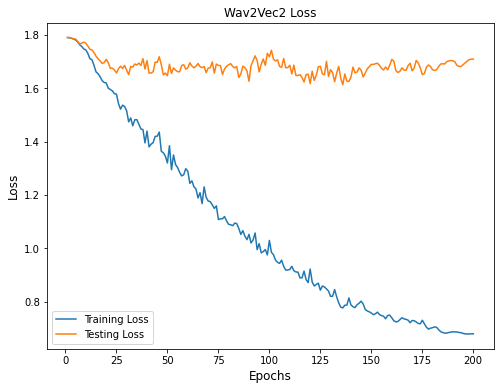

In [20]:
plot_loss(df, title="Wav2Vec2 Loss")

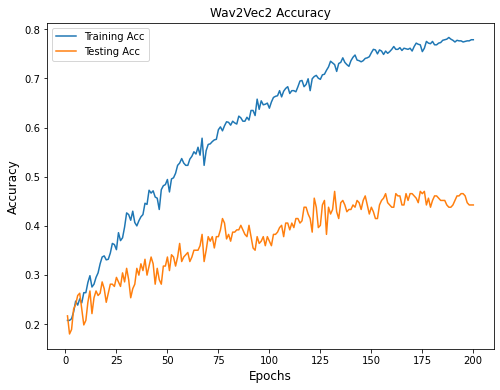

In [21]:
plot_accuracy(df, title="Wav2Vec2 Accuracy")

In [ ]:
model = AutoModelForAudioClassification.from_pretrained(
    "./hf_models/2022-05-03_15-43-45", num_labels=num_labels, label2id=label2id, id2label=id2label
)

In [82]:
batch_size = 40
EPOCHS = 200
output_dir = "./hf_models/"
output_dir = os.path.join(output_dir, time.strftime("%Y-%m-%d_%H-%M-%S"))

training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    logging_strategy="epoch", # log training data stats
    learning_rate=15e-6, #originally 2e-5
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=4,
    logging_steps=10,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    save_total_limit = 2,
    save_strategy = "no",
    load_best_model_at_end=False,
)

trainer = Trainer(
    model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)
trainer.add_callback(CustomCallback(trainer))

In [85]:
trainer.evaluate(encoded_dataset["test"])

***** Running Evaluation *****
  Num examples = 217
  Batch size = 40


{'eval_loss': 1.7090901136398315,
 'eval_accuracy': 0.4423963133640553,
 'eval_runtime': 3.8286,
 'eval_samples_per_second': 56.678,
 'eval_steps_per_second': 1.567}

# Comparing AUC, ROC, and Accuracy for All Models

In [50]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, confusion_matrix, plot_confusion_matrix

def OvR(y_test, class_label):
    '''
    One vs. Rest for ROC/AUC
    '''
    return np.array([1 if i==class_label else 0 for i in y_test])

def torch_prob_predict(model, dataloader):
    model.eval()
    prediction_probs = []
    actual_labels = []
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            features, labels = data
            labels = labels.detach().numpy()
            for j in labels:
                actual_labels.append(j)
            predictions = model(features)
            probs = predictions.detach().numpy()
            # probs = F.softmax(predictions, dim=1).detach().numpy()
            for j in probs:
                prediction_probs.append(j)
    return np.array(prediction_probs), np.array(actual_labels)

## Logistic Regression

In [58]:
# Rerun the log reg cell at the top of the notebook
y_pred_logreg = model_logreg.predict_proba(X_test_logreg)

## MLP

In [48]:
model = MLP(44100, 6)
# model.load_state_dict(torch.load("/home/jupyter/DataMiningFinal/MLP/2022-05-04_00-46-13/epoch_00068_test_loss_15.94401_test_acc_24.424/model.pth"))
model.load_state_dict(torch.load("/home/jupyter/DataMiningFinal/MLP/2022-05-04_01-23-55/epoch_00045_test_loss_14.41495_test_acc_19.816/model.pth"))
MLP_probs, MLP_labels = torch_prob_predict(model, test_loader_MLP)

np.save("./ROC/MLP_probs.npy", MLP_probs)
np.save("./ROC/MLP_labels.npy", MLP_labels)

## ViT

In [51]:
#ViT1
patch_size = (32, 30)
model = ViT(
    image_size = (64, 690),
    patch_size = patch_size,
    num_classes = 6,
    dim = 200,
    depth = 5,
    heads = 16,
    mlp_dim = 300,
    dropout = 0.05,
    emb_dropout = 0.05,
    channels = 1
)

model.load_state_dict(torch.load("/home/jupyter/DataMiningFinal/ViT_models_32_30/2022-05-03_20-16-30/epoch_00260_test_loss_11.62722_test_acc_47.465/model.pth"))
ViT1_probs, ViT1_labels = torch_prob_predict(model, test_loader_ViT)

In [52]:
#ViT2
patch_size = (16, 69)
model = ViT(
    image_size = (64, 690),
    patch_size = patch_size,
    num_classes = 6,
    dim = 200,
    depth = 5,
    heads = 16,
    mlp_dim = 300,
    dropout = 0.05,
    emb_dropout = 0.05,
    channels = 1
)

model.load_state_dict(torch.load("/home/jupyter/DataMiningFinal/ViT_models_16_69/2022-05-03_20-56-37/epoch_00365_test_loss_11.82427_test_acc_47.005/model.pth"))
ViT2_probs, ViT2_labels = torch_prob_predict(model, test_loader_ViT)

np.save("./ROC/ViT2_probs.npy", ViT2_probs)
np.save("./ROC/ViT2_labels.npy", ViT2_labels)

In [53]:
#ViT3
patch_size = (8, 23)
model = ViT(
    image_size = (64, 690),
    patch_size = patch_size,
    num_classes = 6,
    dim = 200,
    depth = 5,
    heads = 16,
    mlp_dim = 300,
    dropout = 0.05,
    emb_dropout = 0.05,
    channels = 1
)

model.load_state_dict(torch.load("/home/jupyter/DataMiningFinal/ViT_models_8_23/2022-05-03_21-36-42/epoch_00275_test_loss_13.16683_test_acc_33.641/model.pth"))
ViT3_probs, ViT3_labels = torch_prob_predict(model, test_loader_ViT)

np.save("./ROC/ViT3_probs.npy", ViT3_probs)
np.save("./ROC/ViT3_labels.npy", ViT3_labels)

In [22]:
# ViT-Base
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=6, in_chans=3)
model.load_state_dict(torch.load("/home/jupyter/DataMiningFinal/ViT_pretrain/2022-05-04_22-36-03/epoch_00003_test_loss_13.93232_test_acc_26.728/model.pth"))
ViTBase_probs, ViTBase_labels = torch_prob_predict(model, test_loader_ViT_transform)

np.save("./ROC/ViTBase_probs.npy", ViTBase_probs)
np.save("./ROC/ViTBase_labels.npy", ViTBase_labels)

## wav2vec2

In [77]:
# https://discuss.huggingface.co/t/saving-loading-model-in-colab-and-making-predictions/6723/5
model = AutoModelForAudioClassification.from_pretrained("./hf_models/2022-05-03_15-43-45", local_files_only=True)
trainer = Trainer(model=model)
trainer.model = model.cuda()
with torch.no_grad():
    trainer.model = model.eval()
y = trainer.predict(encoded_dataset["test"])

# hf_probs = torch.from_numpy(y.predictions)
# hf_probs = F.softmax(torch.from_numpy(y.predictions), dim=1)
# hf_probs = hf_probs.detach().numpy()
hf_probs = y.predictions
hf_labels = y.label_ids

np.save("./ROC/hf_probs.npy", hf_probs)
np.save("./ROC/hf_labels.npy", hf_labels)

loading configuration file ./hf_models/2022-05-03_15-43-45/config.json
Model config Wav2Vec2Config {
  "_name_or_path": "./hf_models/2022-05-03_15-43-45",
  "activation_dropout": 0.1,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": false,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "sum",
  "ctc_zero_infinity": false,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": false,
  "eos_token_id": 2,
  "feat_extract_activation": "gelu",
  "feat_extract_dropout": 0.0,
  "feat_extract_norm": "group",
  

## Plots

In [222]:
LABEL_ENCODING

{'achievement': 0,
 'anger': 1,
 'fear': 2,
 'pain': 3,
 'pleasure': 4,
 'surprise': 5}

In [130]:
CLASS_LABEL = 5

MLP_labels = np.load("./ROC/MLP_labels.npy")
ViT1_labels = np.load("./ROC/ViT1_labels.npy")
ViT2_labels = np.load("./ROC/ViT2_labels.npy")
ViT3_labels = np.load("./ROC/ViT3_labels.npy")
ViTBase_labels = np.load("./ROC/ViTBase_labels.npy")
hf_labels = np.load("./ROC/hf_labels.npy")

MLP_probs = np.load("./ROC/MLP_probs.npy")
ViT1_probs = np.load("./ROC/ViT1_probs.npy")
ViT2_probs = np.load("./ROC/ViT2_probs.npy")
ViT3_probs = np.load("./ROC/ViT3_probs.npy")
ViTBase_probs = np.load("./ROC/ViTBase_probs.npy")
hf_probs = np.load("./ROC/hf_probs.npy")

fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(OvR(y_test_logreg, CLASS_LABEL), y_pred_logreg[:,CLASS_LABEL])
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_MLP, tpr_MLP, thresholds_MLP = roc_curve(OvR(MLP_labels, CLASS_LABEL), MLP_probs[:,CLASS_LABEL])
roc_auc_MLP = auc(fpr_MLP, tpr_MLP)

fpr_ViT1, tpr_ViT1, thresholds_ViT1 = roc_curve(OvR(ViT1_labels, CLASS_LABEL), ViT1_probs[:,CLASS_LABEL])
roc_auc_ViT1 = auc(fpr_ViT1, tpr_ViT1)

fpr_ViT2, tpr_ViT2, thresholds_ViT2 = roc_curve(OvR(ViT2_labels, CLASS_LABEL), ViT2_probs[:,CLASS_LABEL])
roc_auc_ViT2 = auc(fpr_ViT2, tpr_ViT2)

fpr_ViT3, tpr_ViT3, thresholds_ViT3 = roc_curve(OvR(ViT3_labels, CLASS_LABEL), ViT3_probs[:,CLASS_LABEL])
roc_auc_ViT3 = auc(fpr_ViT3, tpr_ViT3)

fpr_ViTBase, tpr_ViTBase, thresholds_ViTBase = roc_curve(OvR(ViTBase_labels, CLASS_LABEL), ViTBase_probs[:,CLASS_LABEL])
roc_auc_ViTBase = auc(fpr_ViTBase, tpr_ViTBase)

fpr_hf, tpr_hf, thresholds_hf = roc_curve(OvR(hf_labels, CLASS_LABEL), hf_probs[:,CLASS_LABEL])
roc_auc_hf = auc(fpr_hf, tpr_hf)

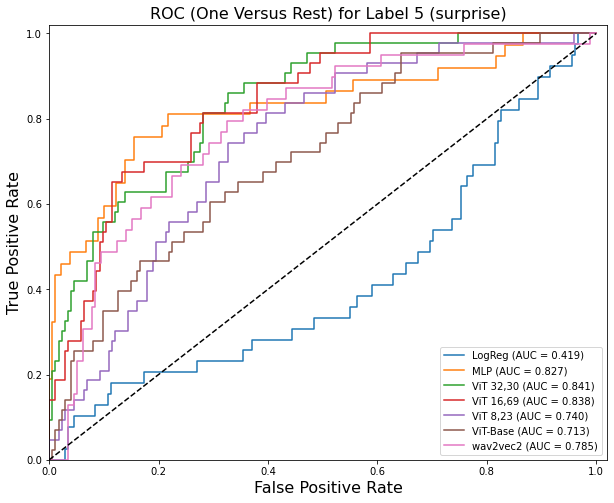

In [131]:
plt.figure(figsize=(10,8))
plt.plot(fpr_logreg, tpr_logreg, label=f'LogReg (AUC = {roc_auc_logreg:.3f})')
plt.plot(fpr_MLP, tpr_MLP, label=f'MLP (AUC = {roc_auc_MLP:.3f})')
plt.plot(fpr_ViT1, tpr_ViT1, label=f'ViT 32,30 (AUC = {roc_auc_ViT1:.3f})')
plt.plot(fpr_ViT2, tpr_ViT2, label=f'ViT 16,69 (AUC = {roc_auc_ViT2:.3f})')
plt.plot(fpr_ViT3, tpr_ViT3, label=f'ViT 8,23 (AUC = {roc_auc_ViT3:.3f})')
plt.plot(fpr_ViTBase, tpr_ViTBase, label=f'ViT-Base (AUC = {roc_auc_ViTBase:.3f})')
plt.plot(fpr_hf, tpr_hf, label=f'wav2vec2 (AUC = {roc_auc_hf:.3f})')

plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.02])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title(f'ROC (One Versus Rest) for Label {CLASS_LABEL} ({dict((v,k) for k,v in LABEL_ENCODING.items())[CLASS_LABEL]})', fontsize=16)
plt.legend(loc="lower right")
plt.savefig(f"./figs/ROC_{CLASS_LABEL}.png")
plt.show()

In [87]:
df_MLP.columns

Index(['epoch', 'train_loss', 'train_accuracy', 'eval_loss', 'eval_accuracy'], dtype='object')

In [83]:
df_MLP = pd.read_pickle("./MLP/2022-05-04_01-23-55/logs.pkl")
df_ViT1 = pd.read_pickle("./ViT_models_32_30/2022-05-03_20-16-30/logs.pkl")
df_ViT2 = pd.read_pickle("./ViT_models_16_69/2022-05-03_20-56-37/logs.pkl")
df_ViT3 = pd.read_pickle("./ViT_models_8_23/2022-05-03_21-36-42/logs.pkl")
df_ViTBase = pd.read_pickle("./ViT_pretrain/2022-05-04_22-36-03/logs.pkl")
df_hf = pd.read_pickle("./hf_models/2022-05-03_15-43-45/logs.pkl")

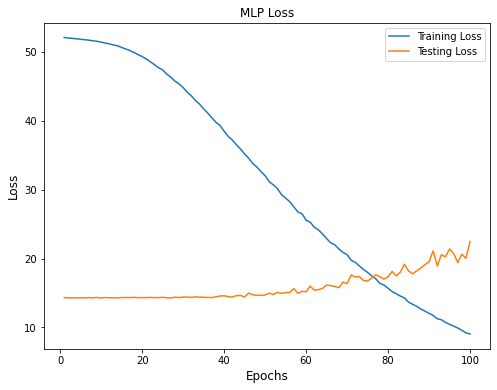

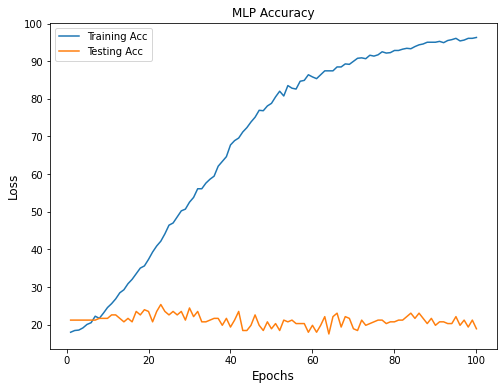

In [104]:
plt.figure(figsize=(8,6))
plt.plot(df_MLP["epoch"], df_MLP["train_loss"], label="Training Loss")
plt.plot(df_MLP["epoch"], df_MLP["eval_loss"], label="Testing Loss")
plt.title("MLP Loss", fontsize=12)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.savefig("./figs/MLPLoss.png")
plt.show()

plt.figure(figsize=(8,6))
plt.plot(df_MLP["epoch"], df_MLP["train_accuracy"], label="Training Acc")
plt.plot(df_MLP["epoch"], df_MLP["eval_accuracy"], label="Testing Acc")
plt.title("MLP Accuracy", fontsize=12)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.savefig("./figs/MLPAcc.png")
plt.show()

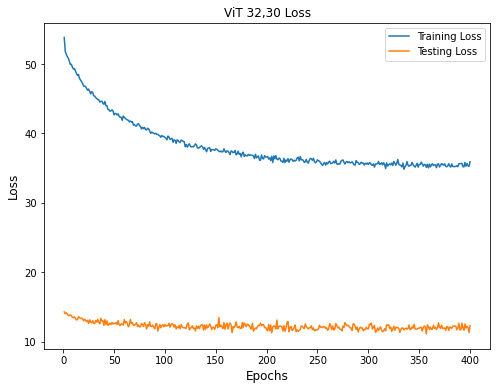

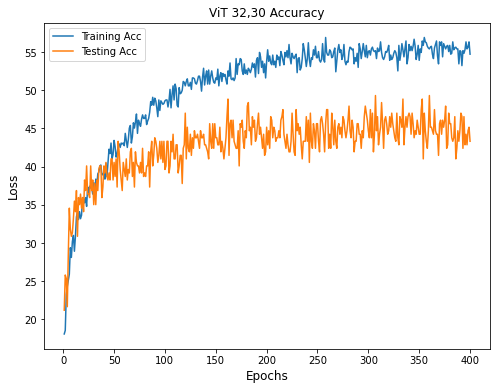

In [105]:
plt.figure(figsize=(8,6))
plt.plot(df_ViT1["epoch"], df_ViT1["train_loss"], label="Training Loss")
plt.plot(df_ViT1["epoch"], df_ViT1["eval_loss"], label="Testing Loss")
plt.title("ViT 32,30 Loss", fontsize=12)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.savefig("./figs/ViT1Loss.png")
plt.show()

plt.figure(figsize=(8,6))
plt.plot(df_ViT1["epoch"], df_ViT1["train_accuracy"], label="Training Acc")
plt.plot(df_ViT1["epoch"], df_ViT1["eval_accuracy"], label="Testing Acc")
plt.title("ViT 32,30 Accuracy", fontsize=12)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.savefig("./figs/ViT1Acc.png")
plt.show()

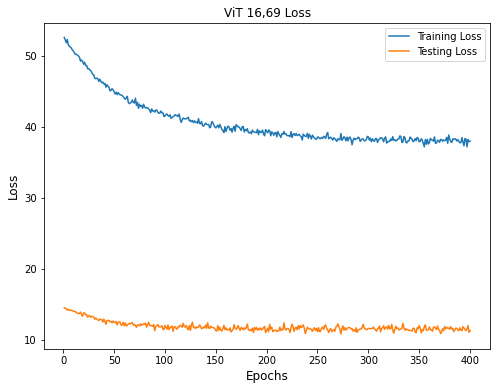

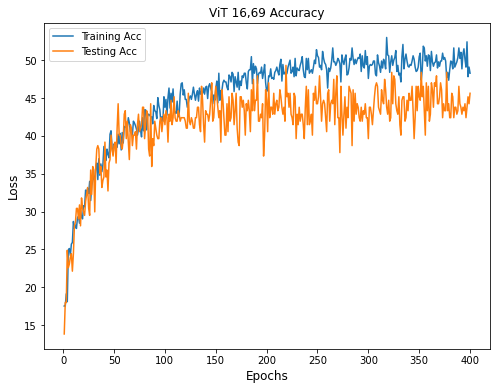

In [106]:
plt.figure(figsize=(8,6))
plt.plot(df_ViT2["epoch"], df_ViT2["train_loss"], label="Training Loss")
plt.plot(df_ViT2["epoch"], df_ViT2["eval_loss"], label="Testing Loss")
plt.title("ViT 16,69 Loss", fontsize=12)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.savefig("./figs/ViT2Loss.png")
plt.show()

plt.figure(figsize=(8,6))
plt.plot(df_ViT2["epoch"], df_ViT2["train_accuracy"], label="Training Acc")
plt.plot(df_ViT2["epoch"], df_ViT2["eval_accuracy"], label="Testing Acc")
plt.title("ViT 16,69 Accuracy", fontsize=12)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.savefig("./figs/ViT2Acc.png")
plt.show()

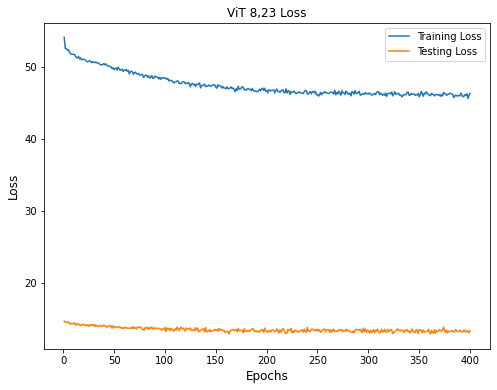

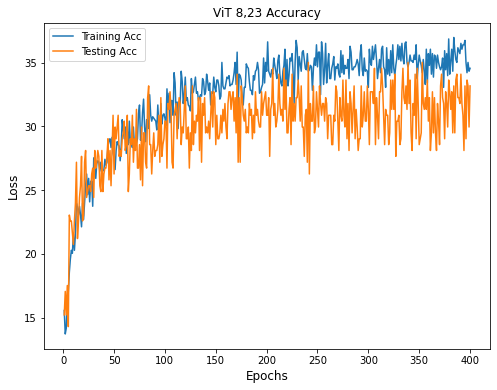

In [107]:
plt.figure(figsize=(8,6))
plt.plot(df_ViT3["epoch"], df_ViT3["train_loss"], label="Training Loss")
plt.plot(df_ViT3["epoch"], df_ViT3["eval_loss"], label="Testing Loss")
plt.title("ViT 8,23 Loss", fontsize=12)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.savefig("./figs/ViT3Loss.png")
plt.show()

plt.figure(figsize=(8,6))
plt.plot(df_ViT3["epoch"], df_ViT3["train_accuracy"], label="Training Acc")
plt.plot(df_ViT3["epoch"], df_ViT3["eval_accuracy"], label="Testing Acc")
plt.title("ViT 8,23 Accuracy", fontsize=12)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.savefig("./figs/ViT3Acc.png")
plt.show()

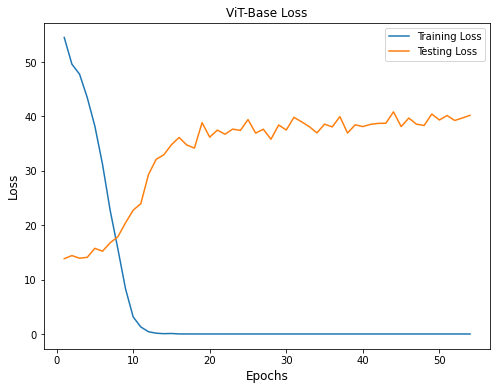

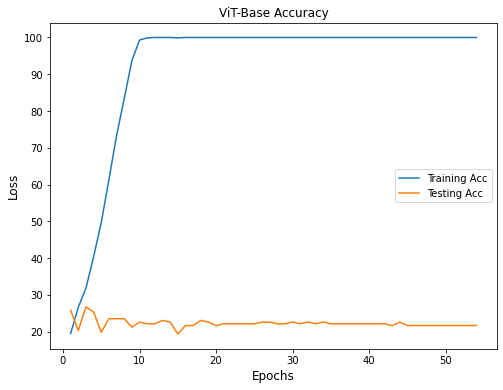

In [108]:
plt.figure(figsize=(8,6))
plt.plot(df_ViTBase["epoch"], df_ViTBase["train_loss"], label="Training Loss")
plt.plot(df_ViTBase["epoch"], df_ViTBase["eval_loss"], label="Testing Loss")
plt.title("ViT-Base Loss", fontsize=12)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.savefig("./figs/ViTBaseLoss.png")
plt.show()

plt.figure(figsize=(8,6))
plt.plot(df_ViTBase["epoch"], df_ViTBase["train_accuracy"], label="Training Acc")
plt.plot(df_ViTBase["epoch"], df_ViTBase["eval_accuracy"], label="Testing Acc")
plt.title("ViT-Base Accuracy", fontsize=12)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.savefig("./figs/ViTBaseAcc.png")
plt.show()

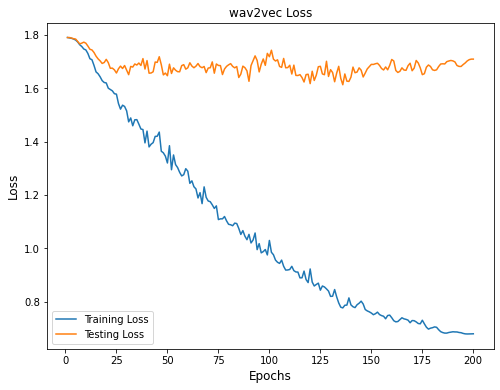

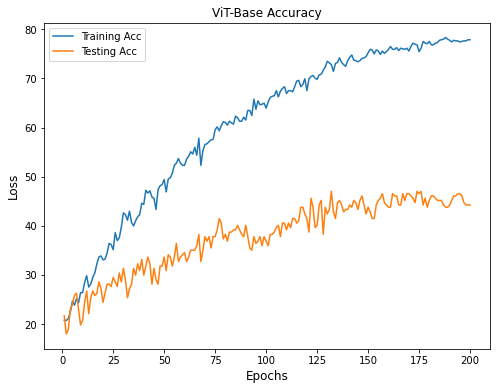

In [115]:
plt.figure(figsize=(8,6))
plt.plot(df_hf["epoch"], df_hf["train_loss"], label="Training Loss")
plt.plot(df_hf["epoch"], df_hf["eval_loss"], label="Testing Loss")
plt.title("wav2vec Loss", fontsize=12)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.savefig("./figs/wav2vecLoss.png")
plt.show()

plt.figure(figsize=(8,6))
plt.plot(df_hf["epoch"], 100*df_hf["train_accuracy"], label="Training Acc")
plt.plot(df_hf["epoch"], 100*df_hf["eval_accuracy"], label="Testing Acc")
plt.title("ViT-Base Accuracy", fontsize=12)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.savefig("./figs/wav2vecAcc.png")
plt.show()

In [114]:
df_hf[130:133]

,epoch,train_loss,train_accuracy,eval_loss,eval_accuracy,step
130,131,0.819961,0.731567,1.658760,0.433180,655
131,132,0.844954,0.728111,1.624251,0.470046,660
132,133,0.817553,0.714286,1.656643,0.428571,665


In [111]:
df_hf['eval_accuracy'].idxmax()

131